In [ ]:
!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/exclusive.mp3
!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/mi_perro_dinamita.mp3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file exclusive.mp3: File exists
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failed writing header
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file mi_perro_dinamita.mp3: File exists
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failed writing header


In [ ]:
from librosa import load, stft, amplitude_to_db
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

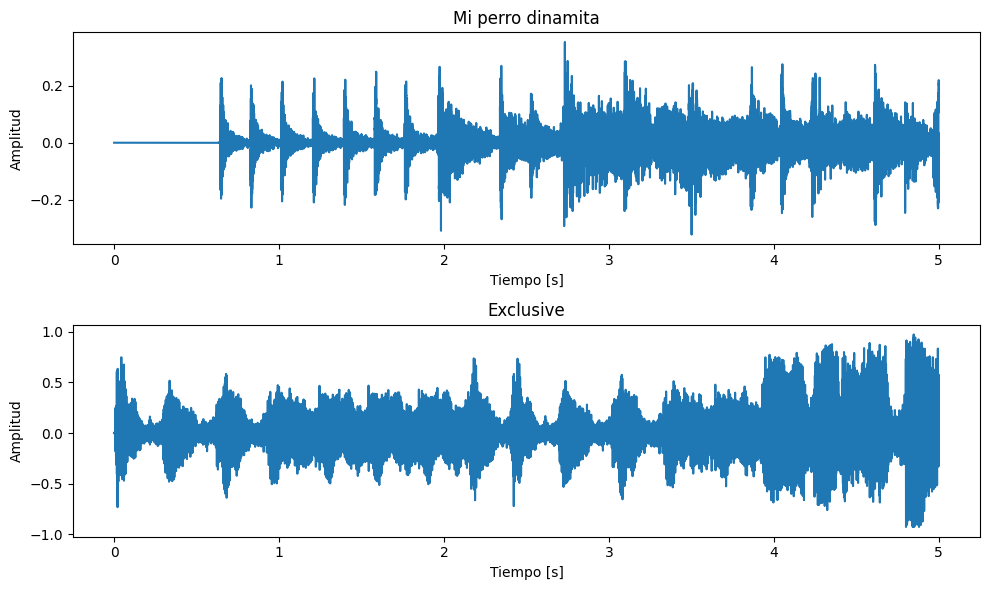

(220500,)


In [ ]:
#Extraigo el fragmento de audio necesario para entrenar

perro_dinami, sr_pd = load("mi_perro_dinamita.mp3", duration=5.0, sr=None)
exclusive, sr_ex = load("exclusive.mp3", duration=5.0, sr=None)


t1 = np.linspace(0, len(perro_dinami)/sr_pd, len(perro_dinami))
t2 = np.linspace(0, len(exclusive)/sr_ex, len(exclusive))

fig, axs = plt.subplots(2, 1, figsize=(10,6))
axs[0].plot(t1, perro_dinami)
axs[0].set_title("Mi perro dinamita")
axs[1].plot(t2, exclusive)
axs[1].set_title("Exclusive")
for ax in axs: ax.set_xlabel("Tiempo [s]"); ax.set_ylabel("Amplitud")
plt.tight_layout()
plt.show()

#Reproduzco los audios

perro_dinami_audio = Audio(perro_dinami, rate=sr_pd)
exclusive_audio = Audio(exclusive, rate=sr_ex)

print(perro_dinami.shape)



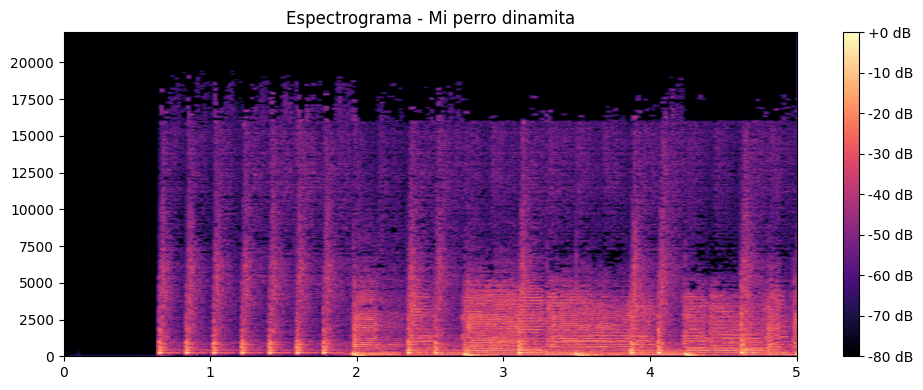

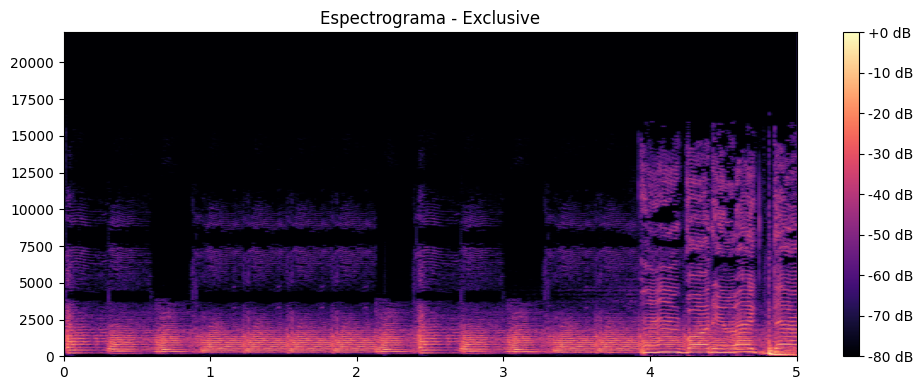

In [ ]:
#Realizo la stft que me da una fft para diferentes ventanas de tiempo a lo largo del fragmento de mi canción
stft_pd = stft(perro_dinami, n_fft=2048, hop_length=512)
stft_ex = stft(exclusive, n_fft=2048, hop_length=512)

#Escalo los datos, normalizandolos al maximo dB, hago lo mismo con todos los sets para que mis predicciones no dependan del volumen
D1 = np.abs(stft_pd)
S_db1 = amplitude_to_db(D1, ref=np.max)
D2 = np.abs(stft_ex)
S_db2 = amplitude_to_db(D2, ref=np.max)

plt.figure(figsize=(10, 4))
plt.imshow(S_db1, aspect='auto', origin='lower',
           extent=[t1.min(), t1.max(), 0, sr_pd / 2], cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma - Mi perro dinamita")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(S_db2, aspect='auto', origin='lower',
           extent=[t2.min(), t2.max(), 0, sr_ex / 2], cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma - Exclusive")
plt.tight_layout()
plt.show()

In [ ]:
data_pd = S_db1.T
data_ex = S_db2.T

X_train = np.vstack([data_pd, data_ex])
y_train = np.hstack([np.zeros([data_pd.shape[0]]), np.ones([data_ex.shape[0]])])

In [ ]:
#Repito para validacion y testeo

perro_dinami_val, sr = load("mi_perro_dinamita.mp3", offset=30.0, duration=5.0, sr=None)
exclusive_val, sr = load("exclusive.mp3", offset=30.0, duration=5.0, sr=None)

stft_pd_val = stft(perro_dinami_val, n_fft=2048, hop_length=512)
stft_ex_val = stft(exclusive_val, n_fft=2048, hop_length=512)

data_pd_val = amplitude_to_db(np.abs(stft_pd_val), ref=np.max).T
data_ex_val = amplitude_to_db(np.abs(stft_ex_val), ref=np.max).T

X_val = np.vstack([data_pd_val, data_ex_val])
y_val = np.hstack([np.zeros([data_pd_val.shape[0]]), np.ones([data_ex_val.shape[0]])])


In [ ]:
perro_dinami_test, sr = load("mi_perro_dinamita.mp3", offset=60.0, duration=30.0, sr=None)
exclusive_test, sr = load("exclusive.mp3", offset=60.0, duration=30.0, sr=None)

stft_pd_test = stft(perro_dinami_test, n_fft=2048, hop_length=512)
stft_ex_test = stft(exclusive_test, n_fft=2048, hop_length=512)

data_pd_test = amplitude_to_db(np.abs(stft_pd_test),ref=np.max).T
data_ex_test = amplitude_to_db(np.abs(stft_ex_test),ref=np.max).T

X_test = np.vstack([data_pd_test, data_ex_test])
y_test = np.hstack([np.zeros([data_pd_test.shape[0]]), np.ones([data_ex_test.shape[0]])])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(862, 1025) (862,)
(862, 1025) (862,)
(5168, 1025) (5168,)


In [ ]:
#Normalizo para los modelos que lo requieran

norm = StandardScaler()

X_train_n = norm.fit_transform(X_train)
X_val_n = norm.transform(X_val)
X_test_n = norm.transform(X_test)

In [ ]:
#Regresión logística

regresor = LogisticRegression()
regresor.fit(X_train_n, y_train)
y_pred = regresor.predict(X_test_n)
acc_reg = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_reg}")

Accuracy: 0.804953560371517


In [ ]:
#LDA se observa que el modelo es sobresimplificado y por lo tanto el accuracy no es bueno

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_n, y_train)
y_pred = lda.predict(X_test_n)
acc_lda = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_lda}")

Accuracy: 0.5654024767801857


In [ ]:
#QDA

best_reg = 0
best_acc = 0
regs = np.linspace(0, 1, 50)

#Intento con varios reg_param ya que ayudan a reducir la colinealidad de las features evitando que las matrices de covarianza se acerquen a ser singulares
for reg in regs:
  qda = QuadraticDiscriminantAnalysis(reg_param = reg)
  qda.fit(X_train_n, y_train)
  y_pred = qda.predict(X_val_n)
  acc = accuracy_score(y_val, y_pred)
  if acc > best_acc:
    best_acc = acc
    best_reg = reg
print(f"Accuracy: {best_acc}, reg_param: {best_reg}")

#QDA se ajusta mejor a la distribucion de los datos

qda = QuadraticDiscriminantAnalysis(reg_param = best_reg)
qda.fit(X_train_n, y_train)
y_pred = qda.predict(X_test_n)
acc_qda = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_qda}")

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Accuracy: 0.8526682134570766, reg_param: 0.42857142857142855


/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Accuracy: 0.8264318885448917


In [ ]:
#KNN
best_acc = 0
ks = np.arange(1, 20)

#Pruebo con varios k, es particular notar que en este caso 5NN es el modelo que predice con mejor accuracy
for k in ks:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_n, y_train)
  y_pred = knn.predict(X_val_n)
  acc = accuracy_score(y_val, y_pred)
  if acc > best_acc:
    best_acc = acc
    best_k = k
print(f"Accuracy: {best_acc}, K: {best_k}")

#Se observa un accuracy de testeo similar al de validación, y una mejor predicción que el QDA

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_n, y_train)
y_pred = knn.predict(X_test_n)
acc_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_knn}")


Accuracy: 0.9060324825986079, K: 5
Accuracy: 0.8844814241486069


In [ ]:
best_acc = 0
best_C = 0

#Del mismo modo evaluo el hiperparámetro C, se observa que el accuracy converge al llegar a C=1 y gamma=0.001,
#el C regula el overfitting al aumentar el margen de mi frontera de decision, el gamma tiene el mismo efecto.
for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    svm = SVC(C=C, gamma=gamma)
    svm.fit(X_train_n, y_train)
    y_pred = svm.predict(X_val_n)
    acc = accuracy_score(y_val, y_pred)
    if acc > best_acc:
      best_acc = acc
      best_C = C
      best_gamma = gamma
print(f"C: {best_C}, gamma: {best_gamma}, Accuracy: {best_acc}")

svm = SVC(kernel='rbf', C = best_C)
svm.fit(X_train_n, y_train)
y_pred = svm.predict(X_test_n)
acc_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_svm}")

C: 1, gamma: 0.001, Accuracy: 0.8979118329466357
Accuracy: 0.853328173374613


In [ ]:
#Arbol de decisión, acá no normalizo

tree = DecisionTreeClassifier(criterion="entropy")
alphas = tree.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']
best_acc = 0
best_alpha = 0

#Al igual que en otros modelos, intento con varios alpha para la poda, hasta encontrar al de mejor accuracy
for alpha in alphas:
  tree = DecisionTreeClassifier(ccp_alpha=alpha, criterion="entropy")
  tree.fit(X_train, y_train)
  y_pred = tree.predict(X_val)
  acc = accuracy_score(y_val, y_pred)
  if acc > best_acc:
    best_acc = acc
    best_alpha = alpha
print(f"Accuracy: {best_acc}, Alpha: {best_alpha}")


tree = DecisionTreeClassifier(ccp_alpha=best_alpha, criterion="entropy")
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_tree}")

Accuracy: 0.8816705336426914, Alpha: 0.25041907467294283
Accuracy: 0.7544504643962848


In [ ]:
#Realizo el PCA con las muestras normalizadas, la normalización en varianza no es necesaria pero si la extracción de la media.
#La transformación reduce la dimensión de las muestras a 30, a diferencia de las 2050 que hay en los datos originales, esto, dependiendo del modelo, logrará dar mejores o peores resultados.
#Al final del código hay una tabla comparativa.

#PCA logra esto al obtener los autovalores de la matriz de covarianza obtenida en los datos de entrenamiento y quedandose solo con los autovectores correspondientes a los n
#autovalores más grandes, es decir, se toman las direcciones donde los datos varían más. Esto en la stft logra que queden los features (frecuencias) donde las canciones
#tienen amplitudes más distintas, ya que estas son las features de mayor varianza.

pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_n)
X_val_pca = pca.transform(X_val_n)
X_test_pca = pca.transform(X_test_n)

In [ ]:
#Se observa que el reglog mejora al reducir el espacio, parece logico ya que reglog es un modelo simple por lo que entrenar con datos con menos features mejora la predicción

regresor = LogisticRegression()
regresor.fit(X_train_pca, y_train)
y_pred = regresor.predict(X_test_pca)
acc_reg_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_reg_pca}")

Accuracy: 0.8523606811145511


In [ ]:
#Mismo caso que con Reglog, el modelo toma suposiciones demasiado simples que no son adecuados cuando hay demasiada features

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
y_pred = lda.predict(X_test_pca)
acc_lda_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_lda_pca}")

Accuracy: 0.7886996904024768


In [ ]:
#QDA no mejora, de hecho empeora, esto puede venir por el hecho de que qda es un modelo suficientemente complejo como para haber representado bien el modelo
#cuando se tienen todos los features y empeorar cuando se pierde información. Se observa tambien que la colinealidad de los datos desaparece al tener ahora menos features
#que samples

best_reg = 0
best_acc = 0
regs = np.linspace(0, 1, 50)
for reg in regs:
  qda = QuadraticDiscriminantAnalysis(reg_param = reg)
  qda.fit(X_train_pca, y_train)
  y_pred = qda.predict(X_val_pca)
  acc = accuracy_score(y_val, y_pred)
  if acc > best_acc:
    best_acc = acc
    best_reg = reg
print(f"Accuracy: {best_acc}, reg_param: {best_reg}")

qda = QuadraticDiscriminantAnalysis(reg_param = best_reg)
qda.fit(X_train_pca, y_train)
y_pred = qda.predict(X_test_pca)
acc_qda_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_qda_pca}")

Accuracy: 0.9269141531322506, reg_param: 0.04081632653061224
Accuracy: 0.7914086687306502


In [ ]:
#No se observa mucha mejora con knn, se puede pensar que es por el mismo motivo que QDA,
#knn lograba la complejidad que tiene el modelo original y por lo tanto descontar featura no aumenta tanto el accuracy

best_acc = 0
ks = np.arange(1, 20)
for k in ks:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_pca, y_train)
  y_pred = knn.predict(X_val_pca)
  acc = accuracy_score(y_val, y_pred)
  if acc > best_acc:
    best_acc = acc
    best_k = k
print(f"Accuracy: {best_acc}, K: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)
acc_knn_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_knn_pca}")


Accuracy: 0.9083526682134571, K: 5
Accuracy: 0.8970588235294118


In [ ]:
#SVM RBF mejora bastante,
#la reducción de dimensiones ayuda a generar una frontera mejor al no ser influenciada por datos que no son significativos en la distribución.
#Se observa que el C de mejor accuracy es mas grande que sin PCA => al validar overfiteo más, por lo tanto es logico decir que la reducción de dimensiones
#de algún modo underfitteo

best_acc = 0
best_C = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    svm = SVC(C=C)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_val_pca)
    acc = accuracy_score(y_val, y_pred)
    if acc > best_acc:
      best_acc = acc
      best_C = C
      best_gamma = gamma
print(f"C: {best_C}, gamma: {best_gamma} Accuracy: {best_acc}")

svm = SVC(kernel='rbf', C = best_C)
svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)
acc_svm_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_svm_pca}")

C: 10, gamma: 0.001 Accuracy: 0.9164733178654292
Accuracy: 0.9022832817337462


In [ ]:
#El arbol de decision si se ve beneficiado al reducir los features ya que estoy generalizando mas los datos y elimino el overfiting, del mismo modo que la poda.

tree = DecisionTreeClassifier(criterion="entropy")
alphas = tree.cost_complexity_pruning_path(X_train_pca, y_train)['ccp_alphas']
best_acc = 0
best_alpha = 0

for alpha in alphas:
  tree = DecisionTreeClassifier(ccp_alpha=alpha, criterion="entropy")
  tree.fit(X_train_pca, y_train)
  y_pred = tree.predict(X_val_pca)
  acc = accuracy_score(y_val, y_pred)
  if acc > best_acc:
    best_acc = acc
    best_alpha = alpha
print(f" Accuracy: {best_acc}, alpha: {best_alpha}")


tree = DecisionTreeClassifier(ccp_alpha=best_alpha, criterion="entropy")
tree.fit(X_train_pca, y_train)
y_pred = tree.predict(X_test_pca)
acc_tree_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_tree_pca}")

 Accuracy: 0.8665893271461717, alpha: 0.016663182876028935
Accuracy: 0.8374613003095975


In [ ]:
#Se presenta una comparacion de accuracys, en general se ve una mejora, mayor para aquellos modelos que son propensos a tener overfitting (Arboles)
#o son demasiado simplificados (reglog, LDA) ya que la reducción de features simplifica la distribución de los datos y da una generalización conveniente.
#Por otro lado, modelos complejos o no tan generalistas como KNN o QDA ven poca mejora o incluso empeoramiento, ya que con una mayora cantidad de informacion lograban
#un modelo más exacto, que se pierde al eliminar features

resultados = {
    'Modelo': ['Log', 'LDA', 'QDA', 'KNN', 'SVC (RBF)', 'Decision Tree'],
    'Test Accuracy': [acc_reg, acc_lda, acc_qda, acc_knn, acc_svm, acc_tree],
    'Test Accuracy (PCA)': [acc_reg_pca, acc_lda_pca, acc_qda_pca, acc_knn_pca, acc_svm_pca, acc_tree_pca]
}

tabla = pd.DataFrame(resultados)
print(tabla)


          Modelo  Test Accuracy  Test Accuracy (PCA)
0            Log       0.804954             0.852361
1            LDA       0.565402             0.788700
2            QDA       0.826432             0.791409
3            KNN       0.884481             0.897059
4      SVC (RBF)       0.853328             0.902283
5  Decision Tree       0.754450             0.837461
